In [1]:
import warnings
warnings.filterwarnings('ignore')

from acv_explainers import ACVTree
import shap

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRFClassifier, XGBClassifier, XGBRegressor
from sklearn.metrics import roc_auc_score
import random 
import time 
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import comb

random.seed(2021)
np.random.seed(2021)

from experiments.exp_linear import *

# Fixed the seed and plot env
random.seed(1)
np.random.seed(1)

palette_colors = {'Leaf':sns.color_palette('tab10')[0], 'Tree SHAP':sns.color_palette('tab10')[3]}
# plt.style.use(['ggplot'])

## Create synthetic data and train RandomForest

In [2]:
p = 0.7
n = 10000
d = 5
mean = np.zeros(d)
# determinitist covariance
cov = p*np.ones(shape=(d, d)) - (p - 1)*np.eye(d)
C = [[]]

# random covariance
# b = np.random.randn(d, d)
# cov = np.dot(b, b.T)

# covariance
coefs = 4*np.random.randn(d)
model_type = 'linear'
k = 10
coefs[k:] = 0

exp = ExperimentsLinear(mean=mean, cov=cov, coefs=coefs, n=n, C=C)
data = exp.data
print('Coefficients of the Linear regression are = {}'.format(coefs))


Coefficients of the Linear regression are = [ 6.49738145 -2.44702565 -2.11268701 -4.29187449  3.46163052]


In [3]:
# model = XGBRegressor()
model = RandomForestRegressor(n_estimators=1)
model.fit(exp.data, exp.y_train)

print('TEST SET MSE = {}'.format(mean_squared_error(model.predict(exp.data_test), exp.y_test)))

TEST SET MSE = 4.3908717109733235


## Build ACVTREE

In [4]:
acvtree = ACVTree(model, data)

100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


## Sampled data for explanations $\mathcal{D}^{Explain}$

In [5]:
n_gen = 50000
nb = 1000
exp2 = ExperimentsLinear(mean=mean, cov=cov, coefs=coefs, n=n_gen, C=C)
data_gen = np.array(exp.data, dtype=np.float)

## Compute SV with the differents estimators on $\mathcal{D}^{Explain}$

In [6]:
plug_sv = acvtree.py_shap_values_notoptimized(data_gen[:nb], C=[[]], data=data)

100%|██████████| 5/5 [00:34<00:00,  6.83s/it]


In [7]:
mc_sv = tree_sv_exact(data_gen[:nb], C=[[]], tree=acvtree, mean=mean, cov=cov, N=10000)

100%|██████████| 5/5 [04:46<00:00, 57.28s/it]


In [8]:
# shap_sv = tree_shap(X=data_gen[:nb], data=data, C=[[]], tree=acvtree, value_function=shap_cond_exp)
explainer_observational = shap.TreeExplainer(model, feature_perturbation='observational')
shap_sv = explainer_observational.shap_values(data_gen[:nb])

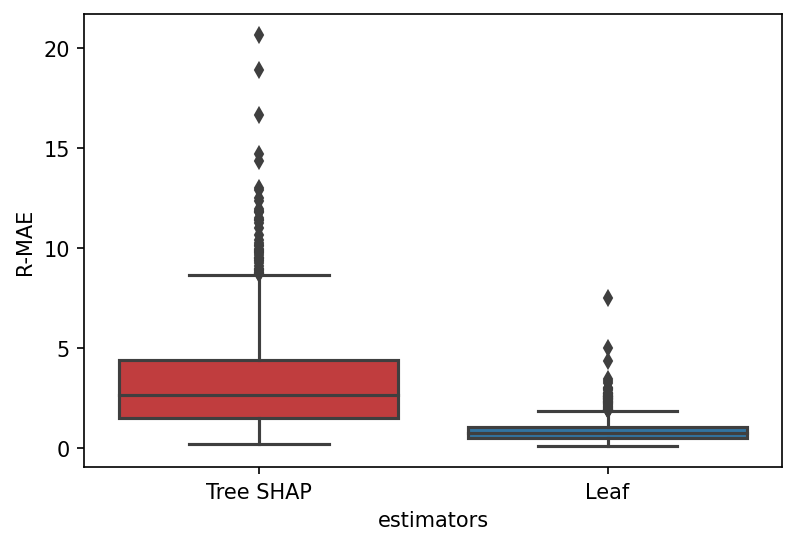

In [9]:
plug_sv = plug_sv.squeeze()
shap_sv = shap_sv.squeeze()
mc_sv = mc_sv.squeeze()

sample_data = np.concatenate([shap_sv, plug_sv], axis=0)

shap_dataFra = pd.DataFrame(data=sample_data.squeeze())
shap_dataFra['estimators'] = nb * ['Tree SHAP'] + nb * ['Leaf'] 

relative = np.zeros(shape=mc_sv.shape)
for i in range(mc_sv.shape[0]):
    for j in range(mc_sv.shape[1]):
        if np.abs(mc_sv[i, j]) <= 1:
            relative[i, j] = 1
        else:
            relative[i, j] = mc_sv[i, j]

# err_monte_carlo = l1_norm(mc_sv- mc_sv)/mc_sv.shape[1]
# err_plugin = l1_norm((plug_sv - mc_sv)/relative)/mc_sv.shape[1]
# err_shap = l1_norm((shap_sv - mc_sv)/relative)/mc_sv.shape[1]
err_monte_carlo = l1_norm(mc_sv- mc_sv)
err_plugin = l1_norm((plug_sv - mc_sv)/relative)
err_shap = l1_norm((shap_sv - mc_sv)/relative)
err_concat = np.concatenate([err_shap, err_plugin], axis=0)
shap_dataFra['R-MAE'] = err_concat

plot = True
if plot:
    fig, ax = plt.subplots(dpi=150)
    sns.boxplot(data=shap_dataFra, x='estimators', y='R-MAE', palette=palette_colors)
#     plt.title('R-MAE Leaf vs TreeSHAP on 1000 new observations ')

<AxesSubplot:xlabel='estimators', ylabel='R-MAE'>

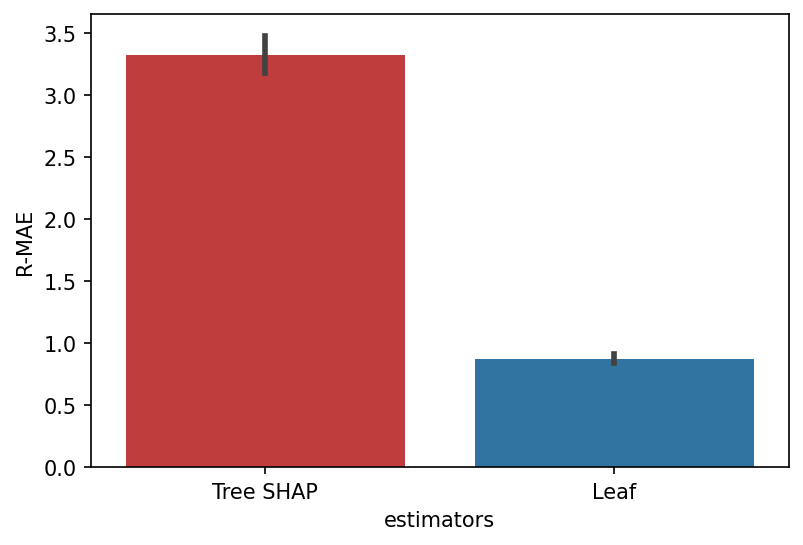

In [10]:
fig, ax = plt.subplots(dpi=150)
sns.barplot(data=shap_dataFra, x='estimators', y='R-MAE', palette=palette_colors)

In [11]:
print('err_shap = {} -- err_plugin = {}'.format(np.mean(err_shap), np.mean(err_plugin)))

err_shap = 3.3212907685000874 -- err_plugin = 0.8714185214659024


In [12]:
from experiments import utils

def return_fi(sv, k=3):
    fi = np.zeros(shape=sv.shape)
    argsort = np.argsort(sv, axis=1)
    for i in range(argsort.shape[0]):
        for j in range(k):
            fi[i, argsort[i, j]] = 1 
    return fi

fi_mc = return_fi(mc_sv)
fi_shap = return_fi(shap_sv)
fi_plug = return_fi(plug_sv)

In [13]:
print('SHAP - TPR - std TPR - FDE - std FDR')
utils.feature_performance_metric(fi_mc, fi_shap)

SHAP - TPR - std TPR - FDE - std FDR


(86.29999971233332, 16.99931365497312, 13.699999954333332, 16.999313654973115)

In [14]:
print('Leaf - TPR - std TPR - FDE - std FDR')
utils.feature_performance_metric(fi_mc, fi_plug)

Leaf - TPR - std TPR - FDE - std FDR


(95.06666634977775, 11.930167137975463, 4.9333333168888895, 11.930167137975461)

# Errors on anomaly samples

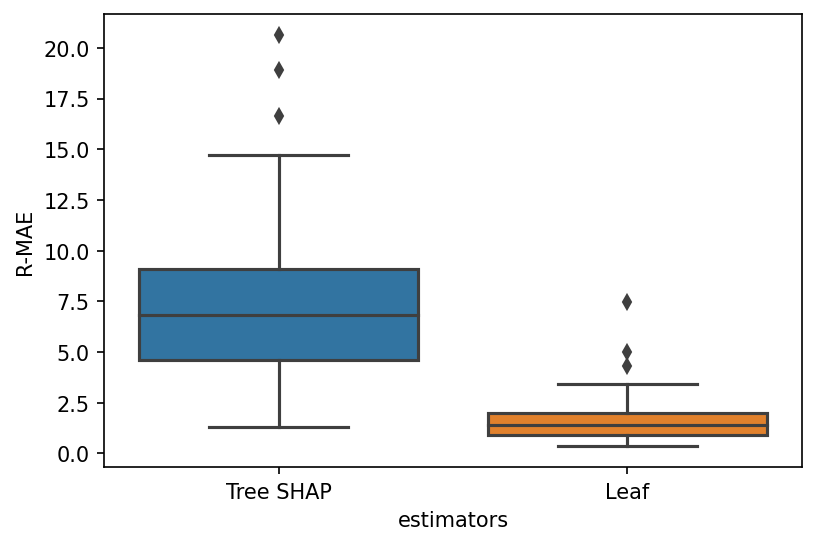

In [15]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=0).fit(data_gen)

ano_idx = clf.predict(data_gen[:nb])
# data_ano = data_gen[:nb][ano_idx == -1]
# nb_ano = np.sum(ano_idx == -1)

nb_ano = np.sum(ano_idx == -1)
idx = ano_idx==-1

sample_data = np.concatenate([shap_sv[idx], plug_sv[idx]], axis=0)

shap_dataFra = pd.DataFrame(data=sample_data.squeeze())
shap_dataFra['estimators'] = nb_ano * ['Tree SHAP'] + nb_ano * ['Leaf'] 

# err_monte_carlo = l1_norm(mc_sv- mc_sv)/mc_sv.shape[1]
# err_plugin = l1_norm((plug_sv - mc_sv)/relative)/mc_sv.shape[1]
# err_shap = l1_norm((shap_sv - mc_sv)/relative)/mc_sv.shape[1]
err_monte_carlo = l1_norm(mc_sv[idx]- mc_sv[idx])
err_plugin = l1_norm((plug_sv[idx] - mc_sv[idx])/relative[idx])
err_shap = l1_norm((shap_sv[idx] - mc_sv[idx])/relative[idx])
err_concat = np.concatenate([err_shap, err_plugin], axis=0)
shap_dataFra['R-MAE'] = err_concat

plot = True
if plot:
    fig, ax = plt.subplots(dpi=150)
    sns.boxplot(data=shap_dataFra, x='estimators', y='R-MAE')

<AxesSubplot:xlabel='estimators', ylabel='R-MAE'>

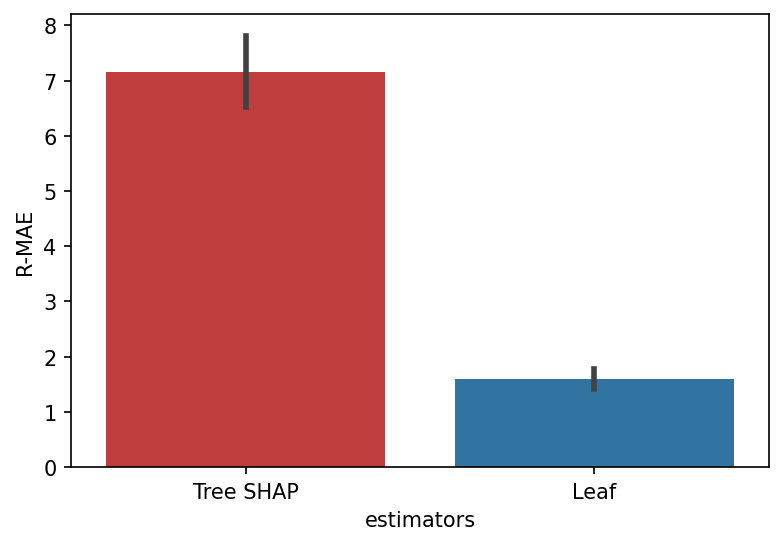

In [16]:
fig, ax = plt.subplots(dpi=150)
sns.barplot(data=shap_dataFra, x='estimators', y='R-MAE', palette=palette_colors)

In [17]:
print('err_shap = {} -- err_plugin = {}'.format(np.mean(err_shap), np.mean(err_plugin)))

err_shap = 7.161038360020557 -- err_plugin = 1.5894692953070493


In [18]:
from experiments import utils

def return_fi(sv, k=3):
    fi = np.zeros(shape=sv.shape)
    argsort = np.argsort(sv, axis=1)
    for i in range(argsort.shape[0]):
        for j in range(k):
            fi[i, argsort[i, j]] = 1 
    return fi

fi_mc = return_fi(mc_sv[idx])
fi_shap = return_fi(shap_sv[idx])
fi_plug = return_fi(plug_sv[idx])

In [19]:
print('SHAP - TPR - std TPR - FDE - std FDR')
utils.feature_performance_metric(fi_mc, fi_shap)

SHAP - TPR - std TPR - FDE - std FDR


(82.9059826296296, 17.22174496790178, 17.09401703703704, 17.221744967901778)

In [20]:
print('Leaf - TPR - std TPR - FDE - std FDR')
utils.feature_performance_metric(fi_mc, fi_plug)

Leaf - TPR - std TPR - FDE - std FDR


(90.88319058024688, 15.484533557161175, 9.116809086419753, 15.484533557161177)

# Errors on normal samples

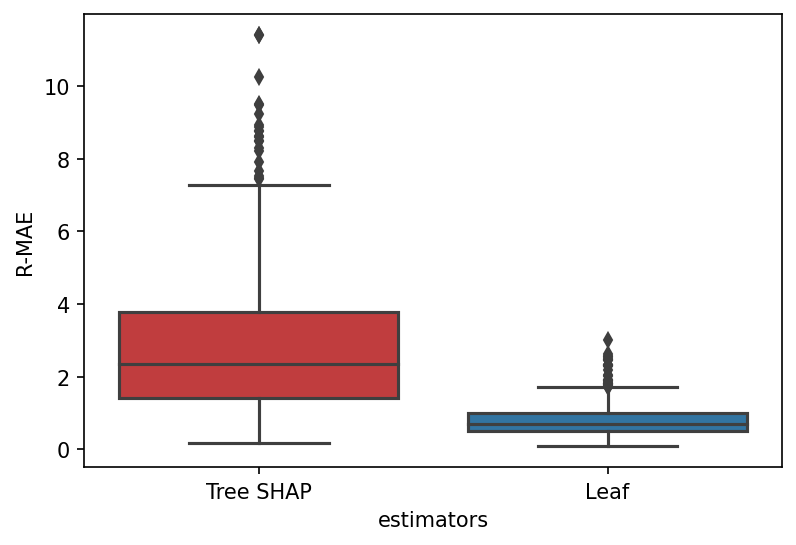

In [21]:
nb_ano = np.sum(ano_idx == 1)
idx = ano_idx==1

sample_data = np.concatenate([shap_sv[idx], plug_sv[idx]], axis=0)

shap_dataFra = pd.DataFrame(data=sample_data.squeeze())
shap_dataFra['estimators'] = nb_ano * ['Tree SHAP'] + nb_ano * ['Leaf'] 

# err_monte_carlo = l1_norm(mc_sv- mc_sv)/mc_sv.shape[1]
# err_plugin = l1_norm((plug_sv - mc_sv)/relative)/mc_sv.shape[1]
# err_shap = l1_norm((shap_sv - mc_sv)/relative)/mc_sv.shape[1]
err_monte_carlo = l1_norm(mc_sv[idx]- mc_sv[idx])
err_plugin = l1_norm((plug_sv[idx] - mc_sv[idx])/relative[idx])
err_shap = l1_norm((shap_sv[idx] - mc_sv[idx])/relative[idx])
err_concat = np.concatenate([err_shap, err_plugin], axis=0)
shap_dataFra['R-MAE'] = err_concat

plot = True
if plot:
    fig, ax = plt.subplots(dpi=150)
    sns.boxplot(data=shap_dataFra, x='estimators', y='R-MAE', palette=palette_colors)

<AxesSubplot:xlabel='estimators', ylabel='R-MAE'>

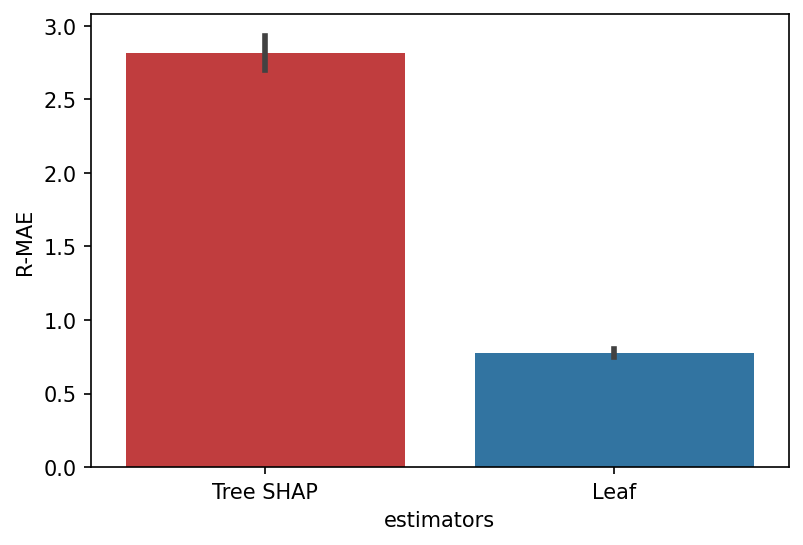

In [22]:
fig, ax = plt.subplots(dpi=150)
sns.barplot(data=shap_dataFra, x='estimators', y='R-MAE', palette=palette_colors)

In [23]:
print('err_shap = {} -- err_plugin = {}'.format(np.mean(err_shap), np.mean(err_plugin)))

err_shap = 2.8125133413110786 -- err_plugin = 0.7762747609456145


In [24]:
def return_fi(sv, k=3):
    fi = np.zeros(shape=sv.shape)
    argsort = np.argsort(sv, axis=1)
    for i in range(argsort.shape[0]):
        for j in range(k):
            fi[i, argsort[i, j]] = 1 
    return fi

In [25]:
fi_mc = return_fi(mc_sv[idx])
fi_shap = return_fi(shap_sv[idx])
fi_plug = return_fi(plug_sv[idx])

In [26]:
from experiments import utils

In [27]:
print('SHAP - TPR - std TPR - FDE - std FDR')
utils.feature_performance_metric(fi_mc, fi_shap)

SHAP - TPR - std TPR - FDE - std FDR


(86.74971658512645, 16.918613508126853, 13.250283081540205, 16.918613508126857)

In [28]:
print('Leaf - TPR - std TPR - FDE - std FDR')
utils.feature_performance_metric(fi_mc, fi_plug)

Leaf - TPR - std TPR - FDE - std FDR


(95.620988733736, 11.260164024578229, 4.379010932930665, 11.260164024578229)